In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!unzip /content/drive/MyDrive/digital_2021.zip
!rm digital_2021/tigers_vs_leopards/images/.DS_Store

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: digital_2021/tigers_vs_leopards/labels/266_IMG_1664_S02.txt  
  inflating: digital_2021/tigers_vs_leopards/labels/002_1422.txt  
  inflating: digital_2021/tigers_vs_leopards/labels/001_92.txt  
  inflating: digital_2021/tigers_vs_leopards/labels/114_IMG_0326_S02.txt  
  inflating: digital_2021/tigers_vs_leopards/labels/003_269.txt  
  inflating: digital_2021/tigers_vs_leopards/labels/03090065_S02.txt  
  inflating: digital_2021/tigers_vs_leopards/labels/217_IMG_0289_S02.txt  
  inflating: digital_2021/tigers_vs_leopards/labels/182_IMAG1787_S02.txt  
  inflating: digital_2021/tigers_vs_leopards/labels/03130213_S02.txt  
  inflating: digital_2021/tigers_vs_leopards/labels/001_1459.txt  
  inflating: digital_2021/tigers_vs_leopards/labels/002_287.txt  
  inflating: digital_2021/tigers_vs_leopards/labels/001_378.txt  
  inflating: digital_2021/tigers_vs_leopards/labels/268_PICT0145_S02.txt  
  inflating: digit

In [8]:
!pip install torchmetrics
!pip install pycocotools
!pip install faster-coco-eval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.6/962.6 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB ? eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvi

In [9]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

from torchvision.models.detection import ssd300_vgg16, SSD300_VGG16_Weights
from torchvision.models.detection.ssd import SSDHead
from torchvision.models.detection._utils import retrieve_out_channels

from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torchvision.ops import box_iou

import torch.utils.data as data
import torch
from tqdm import tqdm

from PIL import Image
import numpy as np
import os

In [10]:
classes = ["background", "tiger", "leopard"]

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [12]:
transform = A.Compose([
    A.Resize(300, 300),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

In [13]:
class CatDataset(data.Dataset):
    def __init__(self, images, labels, transform = None):
        img_list = os.listdir(images)
        self.__annotated_images = []

        for img in img_list:
            filename = os.path.splitext(img)[0]
            image_path = os.path.join(images, filename + ".jpg")
            label_path = os.path.join(labels, filename + ".txt")

            if os.path.exists(label_path) and os.path.getsize(label_path) > 0:
                self.__annotated_images.append((image_path, label_path))
        self.__transform = transform


    def __len__(self):
        return len(self.__annotated_images)


    def __getitem__(self, idx):
        img_path, lbl_path = self.__annotated_images[idx]

        image = Image.open(img_path)
        pw, ph = image.size

        bboxes = []
        class_labels = []
        with open(lbl_path, 'r') as file:
            for line in file:
                bbox = line.split()
                xc, yc, w, h = list(
                    map(float, bbox[1:])
                )
                bboxes.append((
                    min(1, max(0, (xc - w/2)))*pw,
                    min(1, max(0, (yc - h/2)))*ph,
                    min(1, max(0, (xc + w/2)))*pw,
                    min(1, max(0, (yc + h/2)))*ph
                ))

                is_leopard = "_S02" in lbl_path
                class_labels.append(2 if is_leopard else 1)


        image = np.array(image)
        if self.__transform is not None:
            transformed = self.__transform(
                image=image,
                bboxes=bboxes,
                class_labels=class_labels
            )
            image = transformed['image']
            bboxes = transformed['bboxes']
            labels = transformed['class_labels']


        target = {"labels": [], "boxes": []}
        for cls, box in zip(labels, bboxes):
            xmin, ymin, xmax, ymax = box
            target["labels"].append(int(cls))
            target["boxes"].append((xmin, ymin, xmax, ymax))
        target["labels"] = torch.tensor(target["labels"])
        target["boxes"] = torch.tensor(target["boxes"])

        return image, target

In [14]:
dataset = CatDataset(
    "digital_2021/tigers_vs_leopards/images",
    "digital_2021/tigers_vs_leopards/labels",
    transform
)

In [15]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def show_images(dataset, n=3, boxes=False, classes = None):
    for i in range(n):
        idx = np.random.randint(0, len(dataset))
        image, targets = dataset[idx]
        image = image.permute(1, 2, 0)
        _, ax = plt.subplots(1)
        ax.imshow(image)

        if boxes:
            for cls, box in zip(targets["labels"], targets["boxes"]):
                xmin, ymin, xmax, ymax = box
                rect = patches.Rectangle(
                    (xmin, ymin), xmax - xmin, ymax - ymin,
                    linewidth=2, edgecolor='r', facecolor='none'
                )
                ax.add_patch(rect)
                if classes != None:
                    ax.text(
                        xmin, ymin-5, classes[cls],
                        color='yellow', fontsize=12,
                        weight='bold'
                    )

    plt.axis('off')
    plt.show()

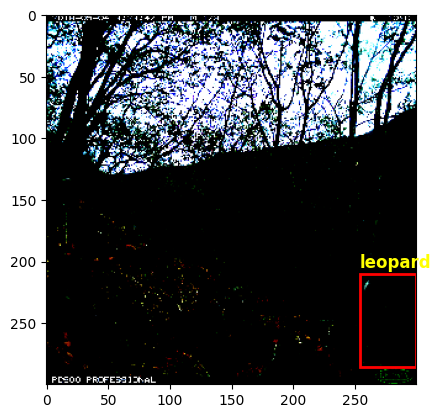

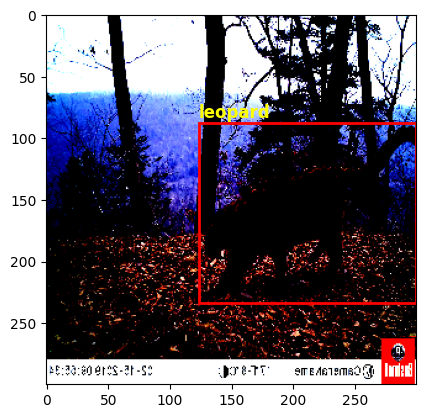

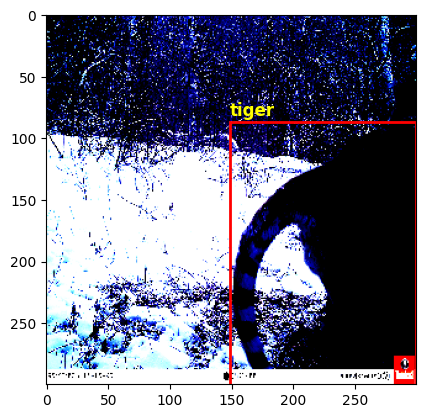

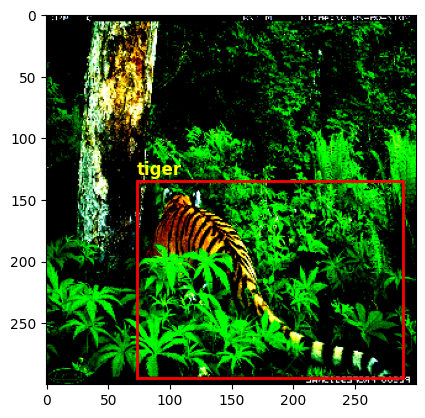

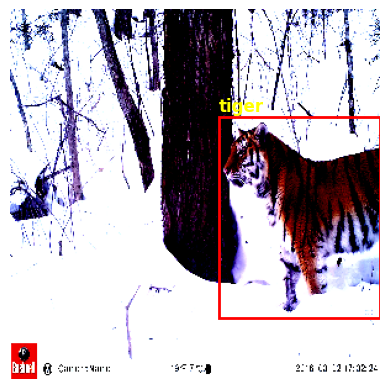

In [16]:
show_images(dataset, n=5, boxes=True, classes=classes)

In [17]:
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_ds, val_ds, test_ds = data.random_split(
    dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

In [18]:
train, val, test = (
    data.DataLoader(
        dataset=train_ds,
        batch_size=8,
        shuffle=True,
        collate_fn=lambda x: tuple(zip(*x))
    ),
    data.DataLoader(
        dataset=val_ds,
        batch_size=8,
        shuffle=False,
        collate_fn=lambda x: tuple(zip(*x))
    ),
    data.DataLoader(
        dataset=test_ds,
        batch_size=8,
        shuffle=False,
        collate_fn=lambda x: tuple(zip(*x))
    )
)

In [19]:
model = ssd300_vgg16(weights=SSD300_VGG16_Weights.DEFAULT)

in_channels = retrieve_out_channels(model.backbone, size=(300, 300))

num_anchors = model.anchor_generator.num_anchors_per_location()

model.head = SSDHead(in_channels, num_anchors, num_classes=len(classes))

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

model = model.to(device)

Downloading: "https://download.pytorch.org/models/ssd300_vgg16_coco-b556d3b4.pth" to /root/.cache/torch/hub/checkpoints/ssd300_vgg16_coco-b556d3b4.pth
100%|██████████| 136M/136M [00:01<00:00, 80.5MB/s]


In [20]:
def eval_predictions(preds, targets, thconf = 0.3, thiou = 0.3):
    tp, fp, fn = 0, 0, 0
    for pred, tgt in zip(preds, targets):
        # pred = {k: v.to("cpu") for k, v in pred.items()}
        # targets = [{k: v.to("cpu") for k, v in t.items()} for t in targets]

        filter = pred["scores"] > thconf

        ious = box_iou(pred["boxes"][filter], tgt["boxes"])
        if len(ious) == 0:
            ious = torch.tensor([[0]])

        _, max_idx = ious.max(dim=0)
        for i, idx in enumerate(max_idx):
            if ious[idx, i].item() > thiou:
                if pred["labels"][filter][idx].item() ==  \
                    tgt["labels"][i].item():
                    tp += 1
                else:
                    fp += 1
            elif len(tgt["labels"] > 0):
                fn += 1

    return tp, fp, fn

In [21]:
def train_ssd(model, train_loader, val_loader, optimizer, device, scheduler, num_epochs=15, save_path="best_ssd.pth"):
    best_loss = float("inf")

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for images, targets in pbar:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            optimizer.zero_grad()
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            losses.backward()
            optimizer.step()
            running_loss += losses.item()
            pbar.set_postfix({
                'loss': losses.item(),
                'cls_loss': loss_dict['classification'].item(),
                'bbox_loss': loss_dict['bbox_regression'].item()
            })

        epoch_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_loss:.4f}")

        model.eval()
        metric = MeanAveragePrecision(iou_type="bbox")
        tp, fp, fn = 0, 0, 0
        with torch.no_grad():
            for images, targets in val_loader:
                images = [img.to(device) for img in images]
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
                preds = model(images, targets)

                tp_batch, fp_batch, fn_batch = eval_predictions(preds, targets, thconf=0.4, thiou=0.4)
                tp += tp_batch
                fp += fp_batch
                fn += fn_batch
                metric.update(preds, [{k: v for k, v in t.items()} for t in targets])

        results = metric.compute()

        print(tp, fp, fn)
        print(f"Precision: {tp / (tp + fp) if (tp + fp) > 0 else 0:.4f}")
        print(f"Recall: {tp / (tp + fn) if (tp + fn) > 0 else 0:.4f}")
        print(f"mAP@0.5: {results['map_50'].item():.4f}")
        print(f"mAP@0.5:0.95: {results['map'].item():.4f}")


        # Сохраняем лучшую модель
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            torch.save(model.state_dict(), save_path)
            print("    Model saved.")

        if scheduler is not None:
            scheduler.step(epoch_loss)

    print("Обучение завершено!")


In [ ]:
train_ssd(model, train, val, optimizer, device, scheduler, num_epochs=25)

Epoch 1/25: 100%|██████████| 609/609 [06:37<00:00,  1.53it/s, loss=5.95, cls_loss=2.87, bbox_loss=3.08]


Epoch 1/25 | Train Loss: 7.5251


/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)


0 0 1043
Precision: 0.0000
Recall: 0.0000
mAP@0.5: 0.0247
mAP@0.5:0.95: 0.0050
    Model saved.


Epoch 2/25: 100%|██████████| 609/609 [06:09<00:00,  1.65it/s, loss=5.32, cls_loss=3.04, bbox_loss=2.28]


Epoch 2/25 | Train Loss: 4.9097
0 0 1043
Precision: 0.0000
Recall: 0.0000
mAP@0.5: 0.0239
mAP@0.5:0.95: 0.0044
    Model saved.


Epoch 3/25: 100%|██████████| 609/609 [06:02<00:00,  1.68it/s, loss=5.24, cls_loss=2.65, bbox_loss=2.59]


Epoch 3/25 | Train Loss: 4.8384
0 0 1043
Precision: 0.0000
Recall: 0.0000
mAP@0.5: 0.0246
mAP@0.5:0.95: 0.0050
    Model saved.


Epoch 4/25: 100%|██████████| 609/609 [05:56<00:00,  1.71it/s, loss=4.7, cls_loss=2.55, bbox_loss=2.15]


Epoch 4/25 | Train Loss: 4.7153
0 0 1043
Precision: 0.0000
Recall: 0.0000
mAP@0.5: 0.0399
mAP@0.5:0.95: 0.0085
    Model saved.


Epoch 5/25: 100%|██████████| 609/609 [05:53<00:00,  1.72it/s, loss=4.23, cls_loss=2.35, bbox_loss=1.88]


Epoch 5/25 | Train Loss: 4.5870
0 0 1043
Precision: 0.0000
Recall: 0.0000
mAP@0.5: 0.0438
mAP@0.5:0.95: 0.0090
    Model saved.


Epoch 6/25: 100%|██████████| 609/609 [05:57<00:00,  1.71it/s, loss=4.6, cls_loss=2.51, bbox_loss=2.09]


Epoch 6/25 | Train Loss: 4.5000
0 0 1043
Precision: 0.0000
Recall: 0.0000
mAP@0.5: 0.0883
mAP@0.5:0.95: 0.0189
    Model saved.


Epoch 7/25: 100%|██████████| 609/609 [05:59<00:00,  1.70it/s, loss=4.53, cls_loss=2.58, bbox_loss=1.95]


Epoch 7/25 | Train Loss: 4.3977
122 0 922
Precision: 1.0000
Recall: 0.1169
mAP@0.5: 0.2644
mAP@0.5:0.95: 0.0712
    Model saved.


Epoch 8/25: 100%|██████████| 609/609 [06:02<00:00,  1.68it/s, loss=5.74, cls_loss=2.71, bbox_loss=3.03]


Epoch 8/25 | Train Loss: 4.1424
292 3 752
Precision: 0.9898
Recall: 0.2797
mAP@0.5: 0.5429
mAP@0.5:0.95: 0.1883
    Model saved.


Epoch 9/25: 100%|██████████| 609/609 [06:03<00:00,  1.67it/s, loss=4.03, cls_loss=2.32, bbox_loss=1.71]


Epoch 9/25 | Train Loss: 3.6674
713 4 338
Precision: 0.9944
Recall: 0.6784
mAP@0.5: 0.7223
mAP@0.5:0.95: 0.2806
    Model saved.


Epoch 10/25: 100%|██████████| 609/609 [05:59<00:00,  1.69it/s, loss=2.82, cls_loss=1.83, bbox_loss=0.99]


Epoch 10/25 | Train Loss: 3.1718
793 3 257
Precision: 0.9962
Recall: 0.7552
mAP@0.5: 0.8154
mAP@0.5:0.95: 0.3541
    Model saved.


Epoch 11/25: 100%|██████████| 609/609 [06:02<00:00,  1.68it/s, loss=3.99, cls_loss=2.76, bbox_loss=1.23]


Epoch 11/25 | Train Loss: 2.7648
862 3 190
Precision: 0.9965
Recall: 0.8194
mAP@0.5: 0.8794
mAP@0.5:0.95: 0.4427
    Model saved.


Epoch 12/25:  53%|█████▎    | 323/609 [03:11<02:41,  1.78it/s, loss=4.65, cls_loss=2.85, bbox_loss=1.8]